# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

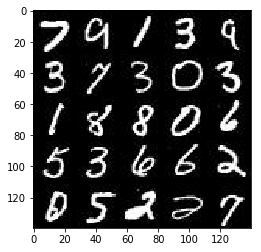

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

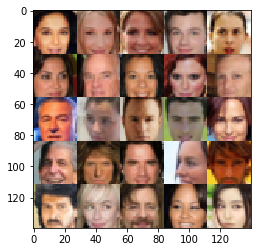

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
drop_rate = 0.3

In [7]:
def LeakyReLU(inputs, alpha=0.2):
    return tf.maximum(inputs * alpha, inputs)

def xavier_init(size, dtype, partition_info):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev, dtype=dtype)

def discriminator(images, reuse=False, is_training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):

        x1 = tf.contrib.layers.conv2d(images, 64, 5, stride=2, padding="same", 
                                     activation_fn=None, weights_initializer=xavier_init)
        relu1 = LeakyReLU(x1)
        #relu1 = tf.layers.dropout(relu1, drop_rate)
        
        x2 = tf.contrib.layers.conv2d(relu1, 128, 5, stride=2, padding="same",
                                     activation_fn=None, weights_initializer=xavier_init)
        bn2 = tf.layers.batch_normalization(x2, training=is_training)
        relu2 = LeakyReLU(bn2)
        #relu2 = tf.layers.dropout(relu2, drop_rate)
        
        x3 = tf.contrib.layers.conv2d(relu2, 256, 5, stride=2, padding="same",
                                     activation_fn=None, weights_initializer=xavier_init)
        bn3 = tf.layers.batch_normalization(x3, training=is_training)
        relu3 = LeakyReLU(bn3)
        #relu3 = tf.layers.dropout(relu3, drop_rate)
        
        flat = tf.contrib.layers.flatten(relu3)
        output = tf.contrib.layers.fully_connected(flat, 1)
    
    return tf.nn.sigmoid(output), output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = LeakyReLU(x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same", kernel_initializer=xavier_init)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = LeakyReLU(x2)
        x2 = tf.layers.dropout(x2, drop_rate, training=is_train)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same", kernel_initializer=xavier_init)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = LeakyReLU(x3)
        x3 = tf.layers.dropout(x3, drop_rate, training=is_train)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding="same", kernel_initializer=xavier_init)
        
        g = tf.tanh(logits)

    return g


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    D_real_out, D_real_digits = discriminator(input_real, reuse=False)
    G_model = generator(input_z, out_channel_dim, True)
    D_fake_out, D_fake_digits = discriminator(G_model, reuse=True)
    
    """
    batch_size = input_real.get_shape().as_list()[0]
    print(batch_size)
    if batch_size is None:
        batch_size = 32
    lam = 10
    eps = tf.random_uniform([batch_size, *input_real.get_shape().as_list()[1:]], minval=0., maxval=1.)
    X_inter = eps * input_real + (1 - eps) * G_model
    grad = tf.gradients(discriminator(X_inter, reuse=True)[1], [X_inter])[0]
    
    grad_norm = tf.sqrt(tf.reduce_sum((grad) ** 2, axis=1))
    grad_pen = lam * tf.reduce_mean(grad_norm - 1.) ** 2
    

    
    D_loss = tf.reduce_mean(D_fake_digits) - tf.reduce_mean(D_real_digits) + grad_pen
    G_loss = -tf.reduce_mean(D_fake_digits)
    """
    smooth = 0.2
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_digits, 
                                                labels=tf.ones_like(D_real_digits) * (1.0 - smooth))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_digits,
                                               labels=tf.ones_like(D_fake_digits) * smooth)
    )
    #G_loss = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_digits,
    #                                           labels=tf.ones_like(D_fake_digits))
    #)
    G_loss = -tf.reduce_mean(D_fake_digits)
    D_loss = tf.reduce_mean(D_fake_digits) - tf.reduce_mean(D_real_digits)
    #D_loss = d_loss_real + d_loss_fake
    
    return D_loss, G_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    d_var = [var for var in variables if var.name.startswith('discriminator')]
    g_var = [var for var in variables if var.name.startswith("generator")]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss,
                                                                                            var_list=d_var)
        G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss,
                                                                                            var_list=g_var)
    """
    D_solver = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(d_loss, var_list=d_var)
    G_solver = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list=g_var)
    """
    return D_solver, G_solver


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
losses = []
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          save_folder=None, base_i=0, load_path=None):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_solver, g_solver = model_opt(d_loss, g_loss, lr, beta1)

    if save_folder and not os.path.exists(save_folder):
        os.mkdir(save_folder)

    with tf.Session() as sess:
        print("begin train")
        saver = tf.train.Saver()
        if load_path:
            saver.restore(sess, load_path)
        else:
            sess.run(tf.global_variables_initializer())
        
        count = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2.0
                
                batch_z = np.random.normal(0., 0.5, size=(batch_size, z_dim))
                #for d_i in range(2):
                    # train discriminator more
                _ = sess.run(d_solver, feed_dict={input_real: batch_images, 
                                                  input_z: batch_z, 
                                                  lr: learning_rate})
                for d_i in range(5):
                    _ = sess.run(g_solver, feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z,
                        lr: learning_rate
                    })
                train_loss_d, train_loss_g = sess.run([d_loss, g_loss], feed_dict={
                    input_z: batch_z, input_real:batch_images
                })
                count += 1
                if count % 100 == 0:
                    print("Epoch {}".format(count),
                         "Discriminator Loss: {:.4f} ".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                losses.append((train_loss_d, train_loss_g))
            
            if save_folder:
                saver.save(sess, "{}/{}_gan.ckpt".format(save_folder, epoch_i+base_i))
    fig, ax = pyplot.subplots()
    loss_ar = np.array(losses)
    pyplot.plot(loss_ar.T[0], label="discriminator", alpha=0.5)
    pyplot.plot(loss_ar.T[1], label="generator", alpha=0.5)
    pyplot.title("Training loss")
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

begin train
Epoch 100 Discriminator Loss: -2.1734  Generator Loss: -9.3435


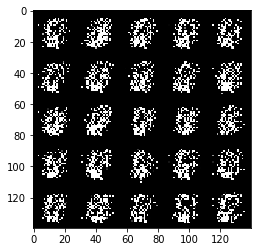

Epoch 200 Discriminator Loss: -5.8214  Generator Loss: -11.9284


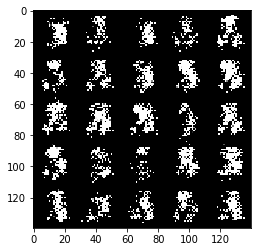

Epoch 300 Discriminator Loss: -10.5598  Generator Loss: -10.0889


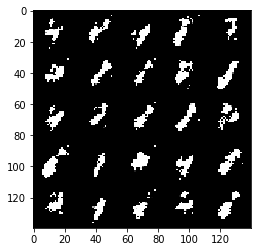

Epoch 400 Discriminator Loss: -18.0804  Generator Loss: -15.3700


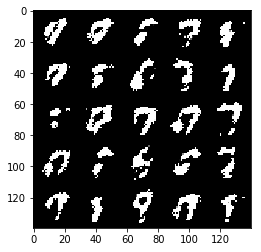

Epoch 500 Discriminator Loss: -40.4728  Generator Loss: -22.2088


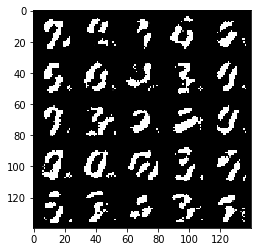

Epoch 600 Discriminator Loss: -130.6600  Generator Loss: -11.4981


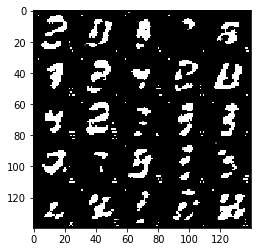

Epoch 700 Discriminator Loss: -302.4103  Generator Loss: -17.1579


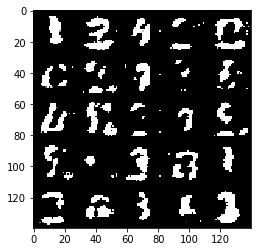

Epoch 800 Discriminator Loss: -529.5870  Generator Loss: -9.1333


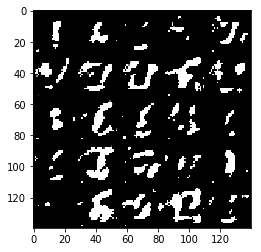

Epoch 900 Discriminator Loss: -779.9954  Generator Loss: -14.5068


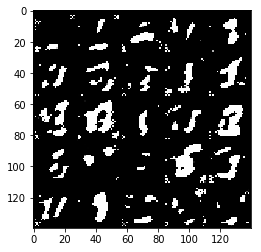

Epoch 1000 Discriminator Loss: -1055.1080  Generator Loss: -3.8343


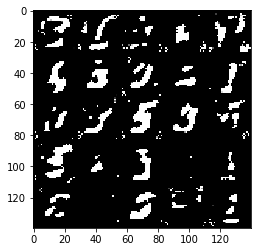

Epoch 1100 Discriminator Loss: -1327.1327  Generator Loss: -5.4220


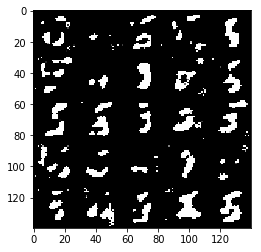

Epoch 1200 Discriminator Loss: -1607.4463  Generator Loss: -11.7561


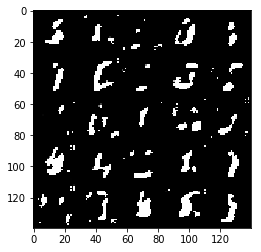

Epoch 1300 Discriminator Loss: -1890.3860  Generator Loss: -21.9485


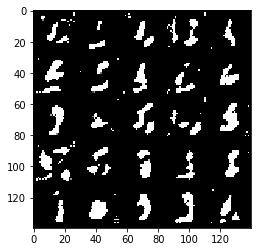

Epoch 1400 Discriminator Loss: -2218.5505  Generator Loss: -7.1899


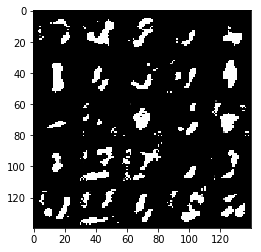

Epoch 1500 Discriminator Loss: -2527.8254  Generator Loss: -36.4640


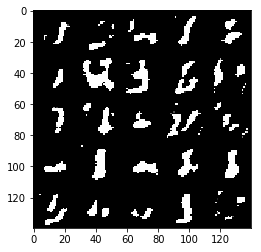

Epoch 1600 Discriminator Loss: -2888.2053  Generator Loss: -16.2501


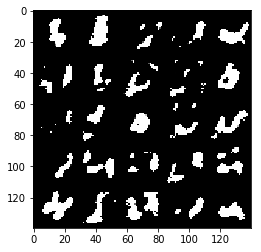

Epoch 1700 Discriminator Loss: -3250.6470  Generator Loss: -22.3522


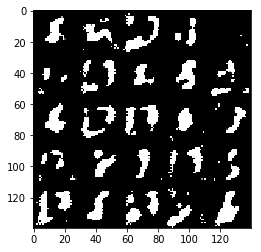

Epoch 1800 Discriminator Loss: -3622.4509  Generator Loss: -14.4973


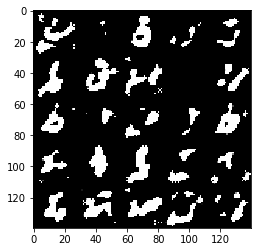

Epoch 1900 Discriminator Loss: -3985.0803  Generator Loss: -17.8948


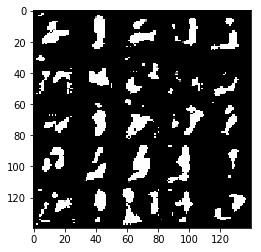

Epoch 2000 Discriminator Loss: -4388.8643  Generator Loss: -3.6659


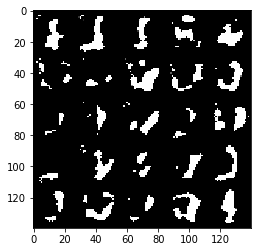

Epoch 2100 Discriminator Loss: -4783.9058  Generator Loss: -6.8671


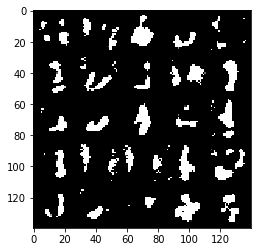

Epoch 2200 Discriminator Loss: -5121.7568  Generator Loss: -43.7334


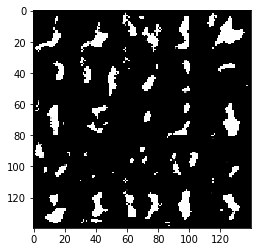

Epoch 2300 Discriminator Loss: -5559.6851  Generator Loss: -15.2325


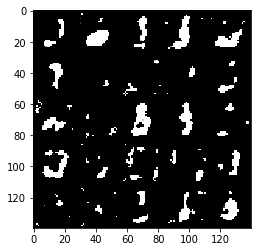

Epoch 2400 Discriminator Loss: -6043.2827  Generator Loss: -22.3288


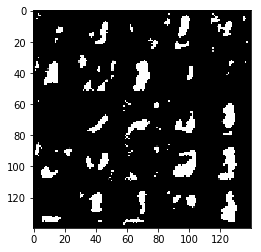

Epoch 2500 Discriminator Loss: -6377.4238  Generator Loss: -22.9579


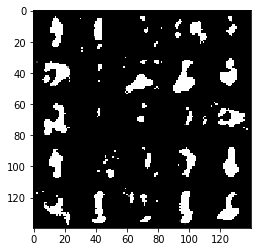

Epoch 2600 Discriminator Loss: -6970.0635  Generator Loss: -0.0000


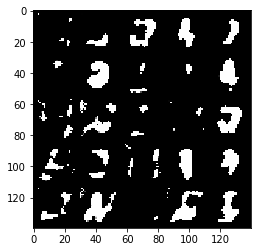

Epoch 2700 Discriminator Loss: -7392.4033  Generator Loss: -0.0000


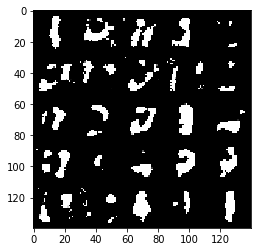

Epoch 2800 Discriminator Loss: -7880.1631  Generator Loss: -0.0000


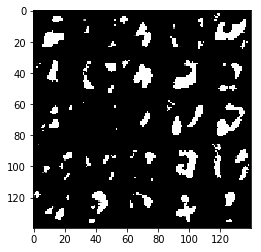

Epoch 2900 Discriminator Loss: -8230.3535  Generator Loss: -0.0000


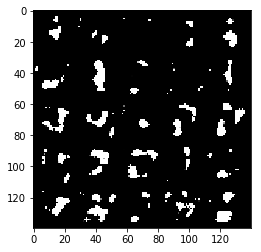

Epoch 3000 Discriminator Loss: -8837.7461  Generator Loss: -2.2413


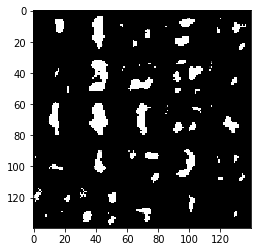

Epoch 3100 Discriminator Loss: -9310.8213  Generator Loss: -3.8361


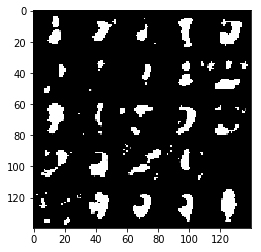

Epoch 3200 Discriminator Loss: -9770.8906  Generator Loss: -3.4746


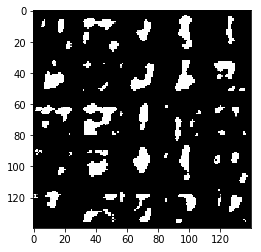

Epoch 3300 Discriminator Loss: -10296.8789  Generator Loss: -0.0000


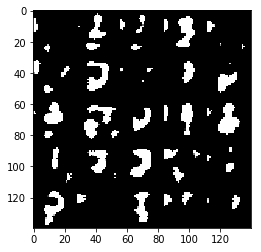

Epoch 3400 Discriminator Loss: -10841.8818  Generator Loss: -31.0732


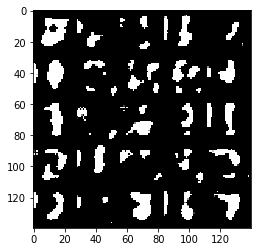

Epoch 3500 Discriminator Loss: -11358.2920  Generator Loss: -19.8781


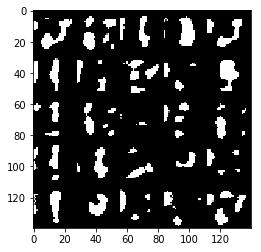

Epoch 3600 Discriminator Loss: -11964.6758  Generator Loss: -14.3831


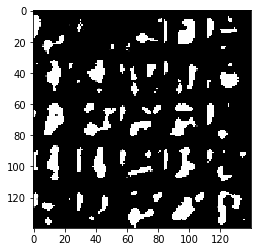

Epoch 3700 Discriminator Loss: -12484.1387  Generator Loss: -20.1408


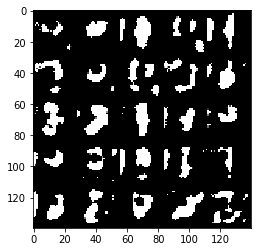

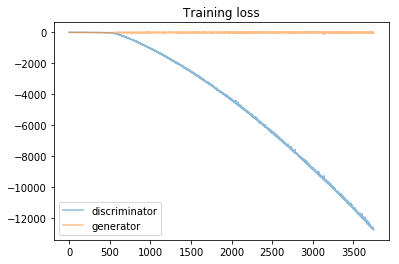

In [ ]:
batch_size = 32
z_dim = 10
learning_rate = 3e-4
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
save_path = "mnist_save"

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, save_path)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

begin train
Epoch 100 Discriminator Loss: -163.6731  Generator Loss: -4.6536


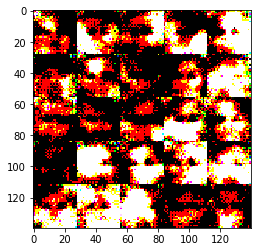

Epoch 200 Discriminator Loss: -829.2487  Generator Loss: -3.1694


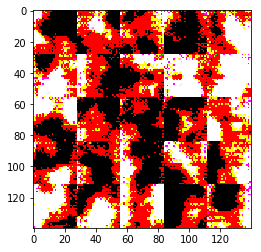

Epoch 300 Discriminator Loss: -1702.5521  Generator Loss: -0.9991


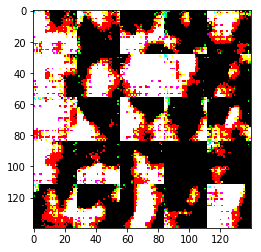

Epoch 400 Discriminator Loss: -2818.5139  Generator Loss: -0.0000


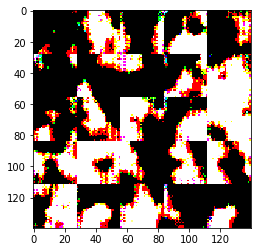

Epoch 500 Discriminator Loss: -4093.8101  Generator Loss: -0.0000


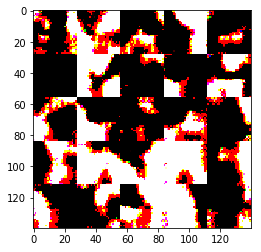

Epoch 600 Discriminator Loss: -5582.0752  Generator Loss: -0.0000


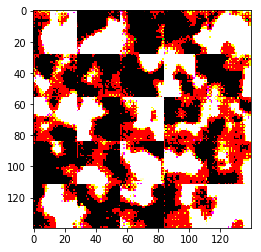

Epoch 700 Discriminator Loss: -7163.2783  Generator Loss: -0.0000


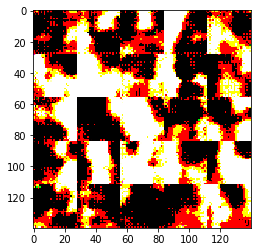

Epoch 800 Discriminator Loss: -9013.1543  Generator Loss: -0.0000


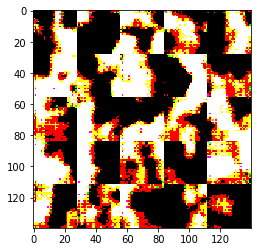

Epoch 900 Discriminator Loss: -10976.4883  Generator Loss: -1.5997


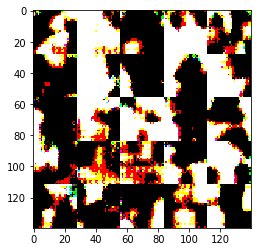

Epoch 1000 Discriminator Loss: -13085.2793  Generator Loss: -2.2645


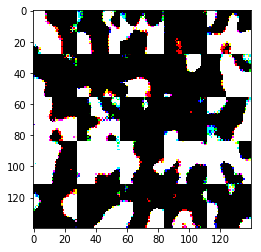

Epoch 1100 Discriminator Loss: -15374.6777  Generator Loss: -0.0000


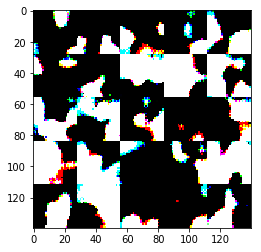

Epoch 1200 Discriminator Loss: -17808.3086  Generator Loss: -0.0000


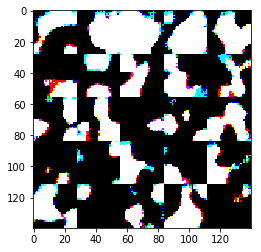

Epoch 1300 Discriminator Loss: -20382.8789  Generator Loss: -0.0000


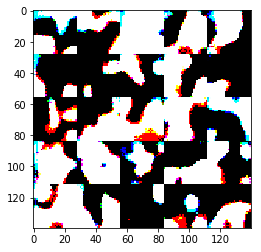

Epoch 1400 Discriminator Loss: -23081.1387  Generator Loss: -0.0000


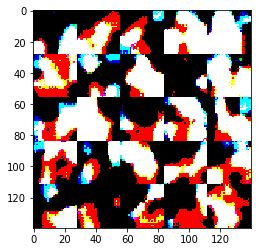

Epoch 1500 Discriminator Loss: -25929.4727  Generator Loss: -0.0000


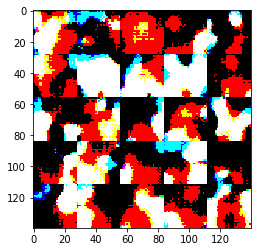

Epoch 1600 Discriminator Loss: -28963.4766  Generator Loss: -0.0000


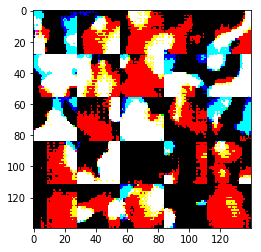

Epoch 1700 Discriminator Loss: -32101.1719  Generator Loss: -0.0000


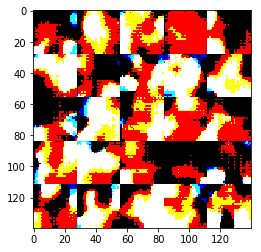

Epoch 1800 Discriminator Loss: -35280.2656  Generator Loss: -0.0000


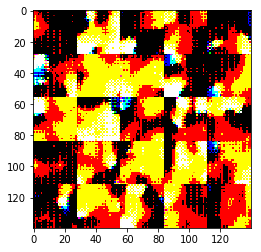

Epoch 1900 Discriminator Loss: -38740.6328  Generator Loss: -0.0000


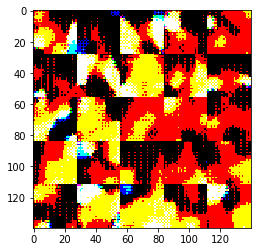

Epoch 2000 Discriminator Loss: -42266.2930  Generator Loss: -0.0000


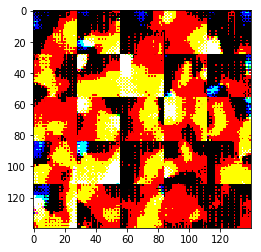

Epoch 2100 Discriminator Loss: -45929.9648  Generator Loss: -0.0000


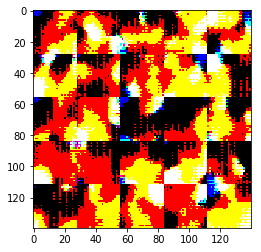

Epoch 2200 Discriminator Loss: -49700.8203  Generator Loss: -0.0000


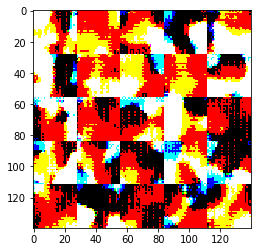

Epoch 2300 Discriminator Loss: -53628.5586  Generator Loss: -0.0000


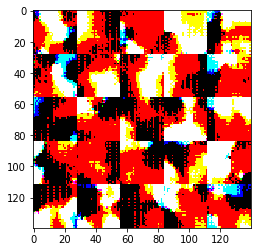

Epoch 2400 Discriminator Loss: -57654.5156  Generator Loss: -0.0000


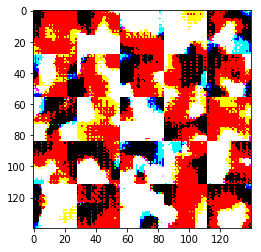

Epoch 2500 Discriminator Loss: -61749.8906  Generator Loss: -0.0000


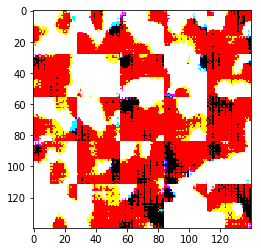

Epoch 2600 Discriminator Loss: -66019.5781  Generator Loss: -0.0000


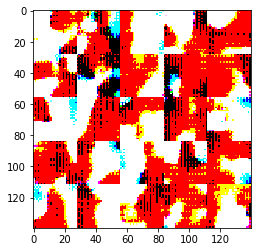

Epoch 2700 Discriminator Loss: -70416.6719  Generator Loss: -0.0000


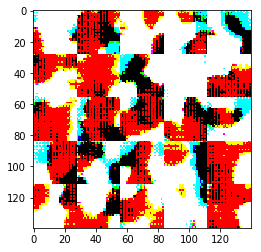

Epoch 2800 Discriminator Loss: -74930.7500  Generator Loss: -0.0000


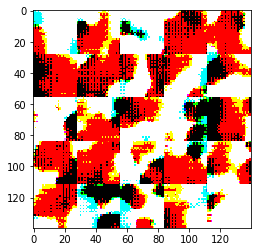

Epoch 2900 Discriminator Loss: -79523.0938  Generator Loss: -0.0000
Epoch 3000 Discriminator Loss: -84258.9062  Generator Loss: -0.0000


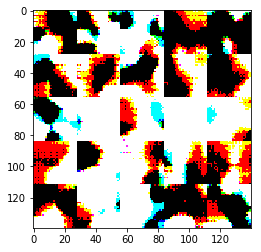

Epoch 3100 Discriminator Loss: -88831.5234  Generator Loss: -0.0000


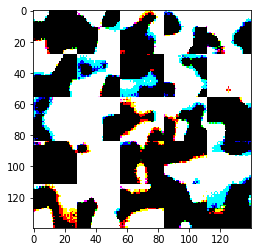

Epoch 3200 Discriminator Loss: -93923.6719  Generator Loss: -0.0000


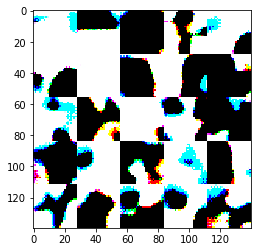

Epoch 3300 Discriminator Loss: -99005.5703  Generator Loss: -0.0000


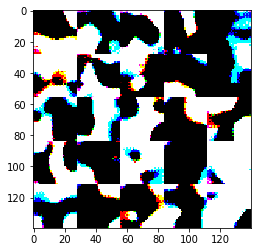

Epoch 3400 Discriminator Loss: -104158.8594  Generator Loss: -0.0000


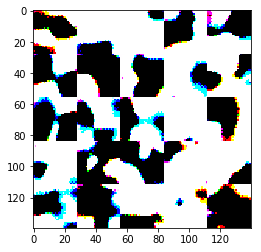

Epoch 3500 Discriminator Loss: -109360.1250  Generator Loss: -0.0000


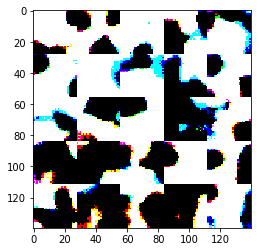

Epoch 3600 Discriminator Loss: -114689.5781  Generator Loss: -0.0000


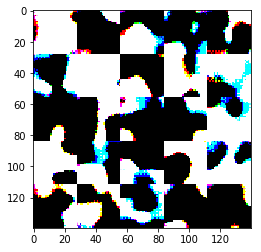

Epoch 3700 Discriminator Loss: -120189.5781  Generator Loss: -0.0000


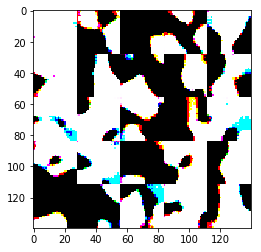

Epoch 3800 Discriminator Loss: -125738.3047  Generator Loss: -0.0000


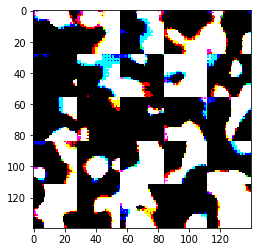

Epoch 3900 Discriminator Loss: -131443.4062  Generator Loss: -0.0000


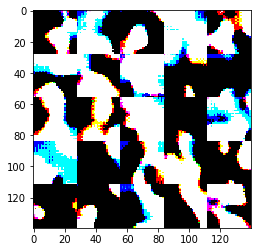

Epoch 4000 Discriminator Loss: -137130.0312  Generator Loss: -0.0000


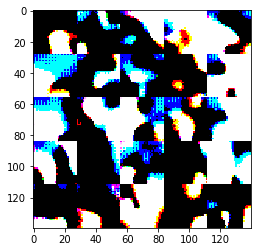

Epoch 4100 Discriminator Loss: -143049.1875  Generator Loss: -0.0000


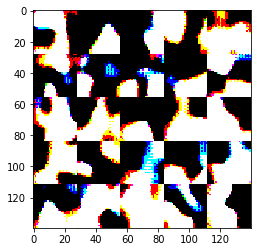

Epoch 4200 Discriminator Loss: -148985.1562  Generator Loss: -0.0000


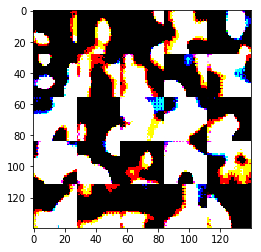

Epoch 4300 Discriminator Loss: -155019.4062  Generator Loss: -0.0000


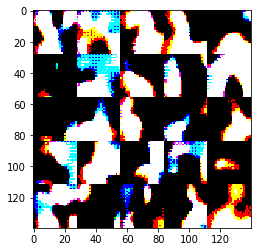

Epoch 4400 Discriminator Loss: -161234.5625  Generator Loss: -0.0000


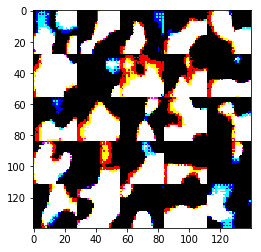

Epoch 4500 Discriminator Loss: -167490.3906  Generator Loss: -0.0000


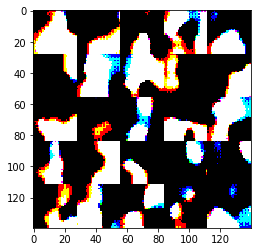

Epoch 4600 Discriminator Loss: -173844.2812  Generator Loss: -0.0000


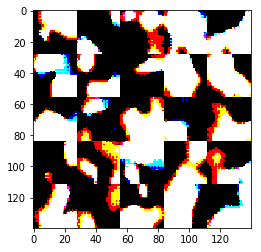

Epoch 4700 Discriminator Loss: -180205.4062  Generator Loss: -0.0000


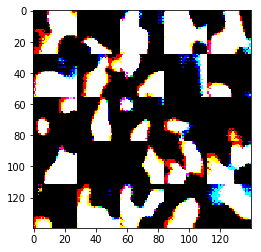

Epoch 4800 Discriminator Loss: -186725.0000  Generator Loss: -0.0000


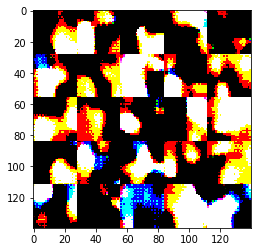

Epoch 4900 Discriminator Loss: -193436.6875  Generator Loss: -0.0000


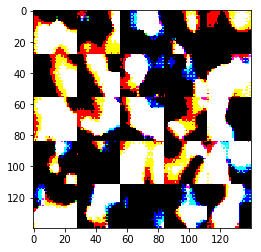

Epoch 5000 Discriminator Loss: -200194.6719  Generator Loss: -0.0000


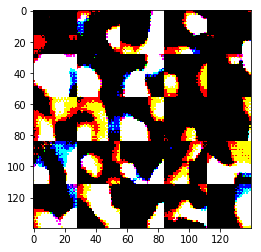

Epoch 5100 Discriminator Loss: -207055.3438  Generator Loss: -0.0000


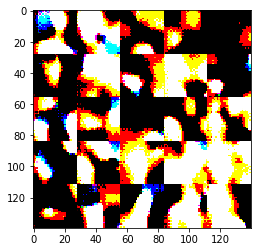

Epoch 5200 Discriminator Loss: -213975.3125  Generator Loss: -0.0000


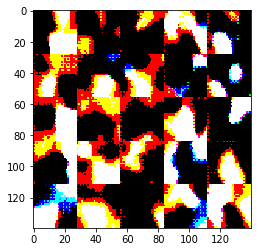

Epoch 5300 Discriminator Loss: -221025.0000  Generator Loss: -0.0000


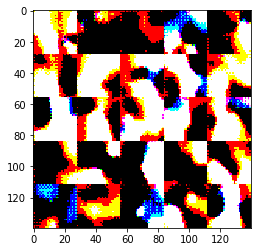

Epoch 5400 Discriminator Loss: -228154.6875  Generator Loss: -0.0000


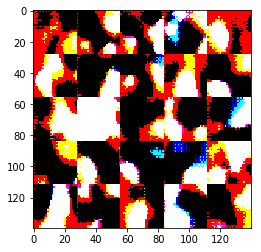

Epoch 5500 Discriminator Loss: -235376.1406  Generator Loss: -0.0000


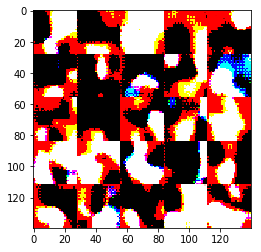

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 1e-3
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1
save_path = "celeba_save"


celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, 
          save_folder=save_path)
""", base_i=8, load_path=save_path+"/7_gan.ckpt"""

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.